## Analysis of Ottawa Wards/Neighbourhoods by Safety using ML 

### Introduction
Ottawa consistently ranks as one of Canada’s safest cities, but some areas offer a quieter and statistically safer environment within the city limits. Whether you’re a new immigrant, a young family, or someone who prioritizes security, a vital question to answer is "What Neighbourhood/Ward do I settle in?". The aim of this project analyze all 23 Ottawa wards to group them from the safest to dangerous using Machine Learning and Data Visualization techniques. I performed analysis using the following criteria:
- Primary Benchmarks considered were Auth Theft, Bike Theft, Criminal Offences (Theft, Assaults, Break and Enter etc), Hate Crime, Homicide and Shootings in each Ward.

#### Import libraries

In [1]:
import pandas as pd # library for data analsysis
import numpy as np
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Import Safety/Crime Types Datasets
For the analysis, I will be ranking the wards based on the following:
- Auto Theft
- Bike Theft
- Criminal Offences (Theft, Assualts, Break and Enter, etc.)
- Hate Crime
- Homicide
- Shootings

In [2]:
# Import csv dataset
auto_theft = pd.read_csv(r'./Dataset/CSV/Auto_Theft_Open_Data.csv') # 2018-2023
bike_theft = pd.read_csv(r'./Dataset/CSV/Bike_Theft_Open_Data.csv') # 2018-2023
crime_offence = pd.read_csv(r'./Dataset/CSV/Criminal_Offences_Open_Data.csv') # 2018 - 2024
hate_crime = pd.read_csv(r'./Dataset/CSV/Hate_Crime_Open_Data.csv') # 2018-2024
homicide = pd.read_csv(r'./Dataset/CSV/Homicide_Open_Data.csv') # 2018 -2023
shootings = pd.read_csv(r'./Dataset/CSV/Shootings_Open_Data.csv') #2018-2023

# Import wards geometry data
ward_map = gpd.read_file(r'./Dataset/GEOJSON/ottawapopulation.geojson')
ott_nh = pd.read_csv(r'./Dataset/CSV/Neighbourhoods.csv')

### Data Cleaning

Get the ward number and name which would be used to rank safety by.

In [3]:
# Keep the ward information
ott_ward = ott_nh[['Ward']].drop_duplicates()

# Split the columns: ward no, name
ott_ward[['Ward_Number', 'Ward_Name']] = ott_ward['Ward'].str.extract(r'Ward (\d+) - (.+)')
ott_ward['Ward_Number'] = ott_ward['Ward_Number'].astype(int)
ott_ward.drop('Ward', axis = 1, inplace = True)

# drop duplicates and store into a dataframe
ott_ward_df = ott_ward.sort_values(by='Ward_Number', ascending=True).reset_index(drop=True)

ott_ward_df.head()

,Ward_Number,Ward_Name
0,1,Orléans East-Cumberland
1,2,Orléans West-Innes
2,3,Barrhaven West
3,4,Kanata North
4,5,West Carleton-March


Checking for duplicates and missing values

Data Cleaning for Bike Theft table.
12130 records & 28 columns
Duplicate values:
 No duplicates in the Bike Theft.

--------------------------------------------------
Data Cleaning for Auto Theft table.
7865 records & 24 columns
Duplicate values:
 No duplicates in the Auto Theft.

--------------------------------------------------
Data Cleaning for Crime Offence table.
252022 records & 19 columns
Duplicate values:
 No duplicates in the Crime Offence.

--------------------------------------------------
Data Cleaning for Hate Crime table.
1689 records & 17 columns
Duplicate values:
 No duplicates in the Hate Crime.

There are no missing values in Hate Crime.

--------------------------------------------------
Data Cleaning for Homicide table.
84 records & 13 columns
Duplicate values:
 No duplicates in the Homicide.

There are no missing values in Homicide.

--------------------------------------------------
Data Cleaning for Shootings table.
413 records & 20 columns
Duplicate values:
 No

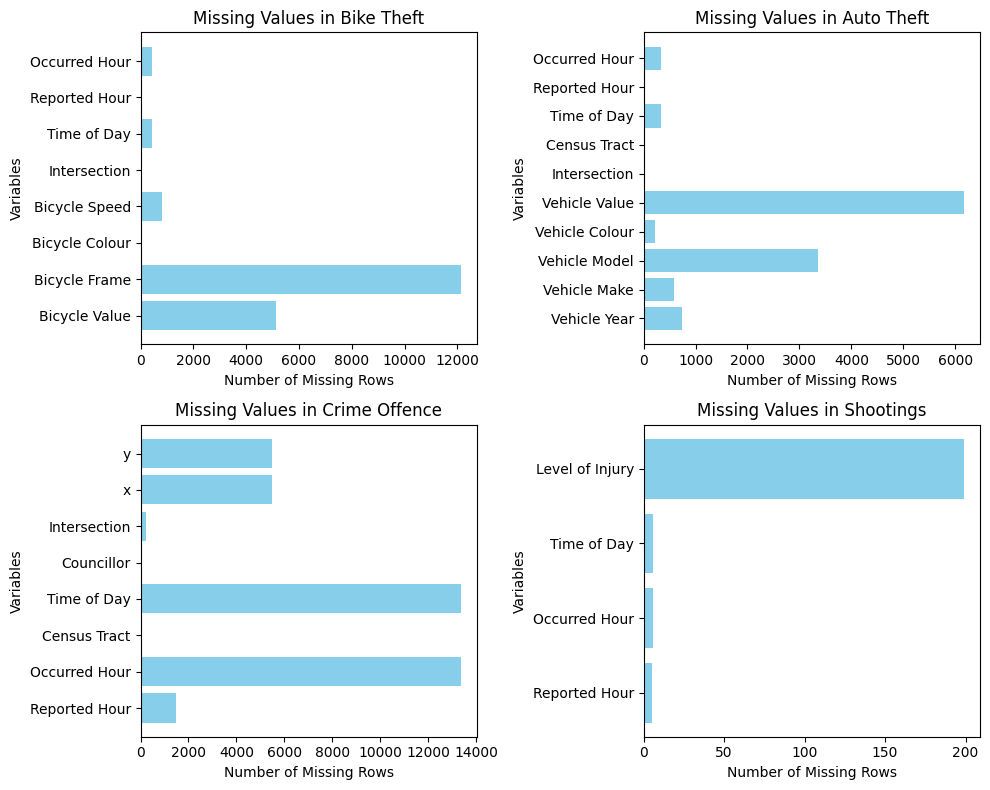

In [4]:
def examine_data(dataframes, df_names):
    """
    Examines a list of dataframes for duplicates and missing values.
    Plots the number of missing values for each dataframe.

    Parameters:
    - dataframes: list of pandas DataFrame objects
    - df_names: list of names for the dataframes (for labeling)
    """

    # Initialize the plot grid
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()  # Flatten the grid to iterate easily
    plot_idx = 0

    for df, name in zip(dataframes, df_names):
        print(f"Data Cleaning for {name} table.")
        print(f"{df.shape[0]} records & {df.shape[1]} columns")

        # Check duplicate values
        duplicates = df.duplicated().sum()
        if duplicates == 0:
            print(f"Duplicate values:\n No duplicates in the {name}.\n")
        else:
            print(f"There are {duplicates} duplicates in the {name}.\n")

        # Missing values
        missing = df.isna().sum().reset_index().rename(columns={0: 'missing', 'index': 'variable'})
        nan_rows = missing[missing['missing'] > 0]  # Columns with missing values

        if nan_rows.empty:
            print(f"There are no missing values in {name}.\n")
        else:
            # Plot missing values
            ax = axes[plot_idx]
            ax.barh(nan_rows['variable'], nan_rows['missing'], color='skyblue')
            ax.set_title(f'Missing Values in {name}')
            ax.set_xlabel("Number of Missing Rows")
            ax.set_ylabel("Variables")
            plot_idx += 1

        print('-' * 50)

    # Remove unused subplots
    for i in range(plot_idx, len(axes)):
        fig.delaxes(axes[i])

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Pass the dataframes and run function
dataframes = [bike_theft, auto_theft, crime_offence, hate_crime, homicide, shootings]
df_names = ["Bike Theft", "Auto Theft", "Crime Offence", "Hate Crime", "Homicide", "Shootings"]
examine_data(dataframes, df_names)


The dataset represents recorded offences, with each row corresponding to a single incident. Since missing values do not significantly impact the data's integrity, they will be retained for analysis and model training.

### Data Wrangling
Feature Engineering: formatiing the data into meaningful format for analysis.

In [5]:
# function that takes the ward, seperates them, then aggregate count each , filter for time period

def prepare_data(dataframes):

    """
    Takes a list of dataframes, processes each to extract ward information,
    filters for data from 2018 onward, aggregates the count of incidents by ward,
    and combines the results into a single dataframe.

    Parameters:
    - dataframes: list of pandas DataFrame objects

    Returns:
    - A single pandas DataFrame with aggregated data for all wards across the input dataframes.
    """

    aggregate_data = pd.DataFrame()
    
    # pass a list of dataframes into the function
    for current_df in dataframes:

        # Extract the ward number and name
        current_df[['Ward_Number', 'Ward_Name']] = current_df['Ward'].str.extract(r'Ward (\d+) - (.+)')
        # Convert Ward_Number to consistent type
        current_df['Ward_Number'] = pd.to_numeric(current_df['Ward_Number'], errors='coerce')

        # filter the year to 2018 - newest
        current_df['Occurred Date'] = pd.to_datetime(current_df['Occurred Date'])
        current_df = current_df[current_df['Occurred Date'] >= '2018'].reset_index(drop=True)

        
        # aggregate for each ward
        agg_df = current_df.groupby(['Ward_Number']).agg({'OBJECTID': 'count'}).reset_index().rename({'OBJECTID':'Incident_Count_{i}'}, axis = 1)

        # Merge the aggregated data into the main dataframe
        if aggregate_data.empty:
            aggregate_data = agg_df
        else:
            aggregate_data = pd.merge(aggregate_data, agg_df, on='Ward_Number', how='outer', suffixes=(None, '_{i}'))

        aggregate_data.fillna(0, inplace=True)

    return aggregate_data
        

# return a single dataframe
dataframes = [bike_theft, auto_theft, crime_offence, hate_crime, homicide, shootings]
df = prepare_data(dataframes)

# apply new column names
column_names = ['wardNumber','bikeTheft','autoTheft','crimeOffence','hateCrime','homicide','shootings']
df.columns = column_names
df.head()

C:\Users\Razak\AppData\Local\Temp\ipykernel_26584\213708627.py:28: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  current_df['Occurred Date'] = pd.to_datetime(current_df['Occurred Date'])


,wardNumber,bikeTheft,autoTheft,crimeOffence,hateCrime,homicide,shootings
0,1,181,310,4946,37,4.0,6
1,2,115,262,5229,43,0.0,10
2,3,171,343,6442,66,1.0,1
3,4,138,191,4645,54,0.0,3
4,5,11,101,1810,22,0.0,3


#### Correlation Matrix
To check the relationships between each safety/criminal variable across all wards

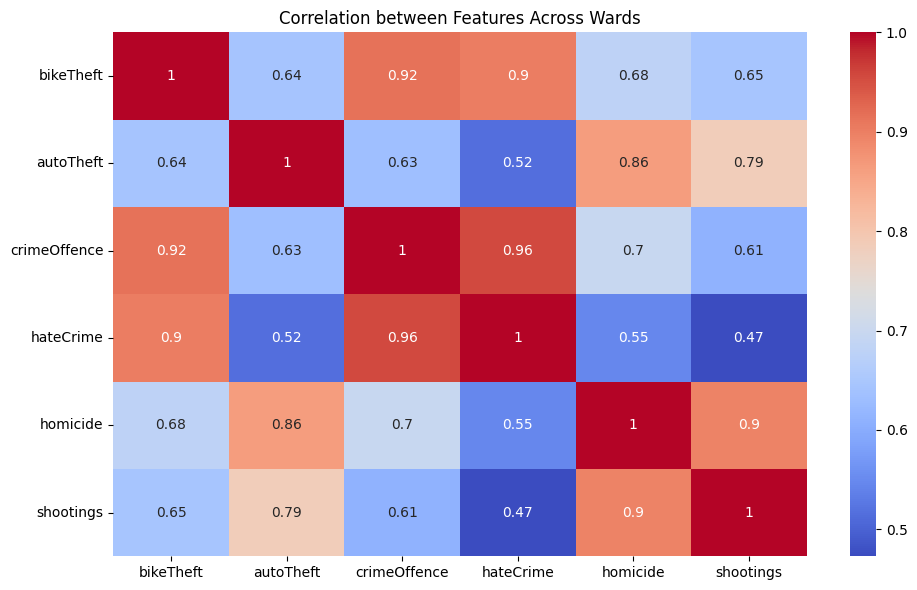

In [6]:
plt.figure(figsize=(10,6))
sns.heatmap(df.drop('wardNumber',axis = 1).corr(), annot=True, cmap='coolwarm')

plt.title('Correlation between Features Across Wards')
plt.tight_layout()
plt.show()

#### Insights and Observations
We can observe how different safety/criminal problems are related to one another and how likely they are to occur in the same Ward/Area.
1. The high correlations among crime types (e.g., Bike Theft, Criminal Offences, Hate Crime) suggest that Wards with one type of crime often experience others, potentially due to systemic factors like socioeconomic conditions, law enforcement presence, or community safety.
2. Certain crimes, like homicide and shootings, have logical pairings because one often leads to the other.

## Machine Learning

#### Scale and Standardization

In [7]:
new_df = df.copy()

# scale
scaler = StandardScaler()
scaled_features = scaler.fit_transform(new_df.drop('wardNumber', axis = 1))

# a new dataframe with the fitted/scaled data
df_features = pd.DataFrame(scaled_features, columns=new_df.columns[1:])
df_features.head()

,bikeTheft,autoTheft,crimeOffence,hateCrime,homicide,shootings
0,-0.475894,-0.145959,-0.543422,-0.620756,0.127688,-0.640304
1,-0.572898,-0.558079,-0.515387,-0.509020,-0.893819,-0.411794
2,-0.490592,0.137373,-0.395224,-0.080698,-0.638442,-0.925941
3,-0.539094,-1.167672,-0.573240,-0.304170,-0.893819,-0.811686
4,-0.725753,-1.940397,-0.854084,-0.900096,-0.893819,-0.811686


## KMeans Clustering

#### Elbow Method
Used the elbow methid to determine the number of clusters.


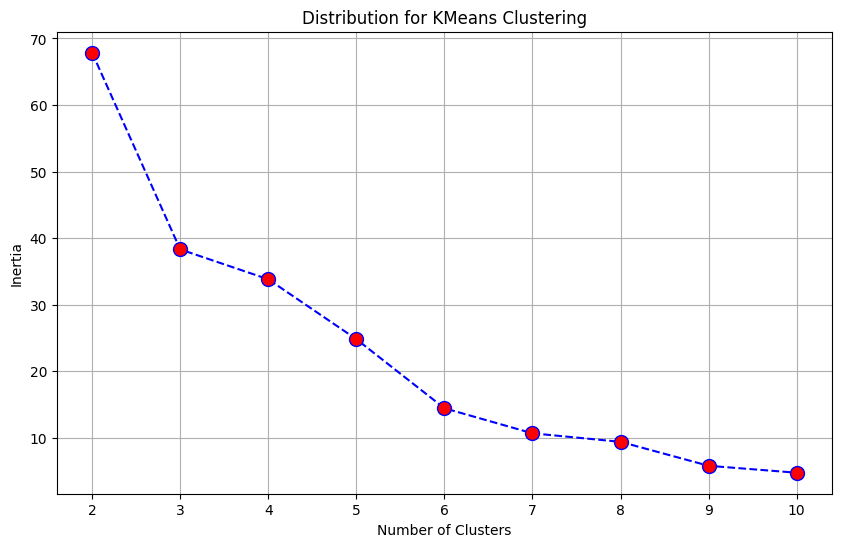

In [8]:
# Create a list from 2-10. 
num_clusters = [i for i in range(2, 11)]

def kmeans_inertia(num_clusters, x_vals):
    
    inertia = []
    for num in num_clusters:
        kms = KMeans(n_clusters=num, random_state=42)
        kms.fit(x_vals)
        inertia.append(kms.inertia_)
    
    return inertia

# Calculate inertia for k=2-10
inertia = kmeans_inertia(num_clusters, scaled_features)

# Create an elbow plot
plt.figure(figsize = (10,6))
plt.plot(num_clusters, inertia, color = 'blue', linestyle = '--', marker = 'o', markerfacecolor = 'red', markersize = 10)
plt.title('Distribution for KMeans Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


The above graph visualize the elbow at 3 clusters, which will be the optimal number of segments to group our dataset. But I will use 6 to get better granularity of the crime per wards.

NOTE - The more the cluster size, the better the algorithm will properly group the wards.

In [31]:
# Fit a 6-cluster model to the data
cluster_no = 6
kmeans = KMeans(n_clusters = cluster_no, random_state=42)
kmeans.fit(scaled_features)

print('Unique labels:', np.unique(kmeans.labels_))

# Create a new column that indicates cluster assignment in our dataset
new_df['cluster'] = kmeans.labels_
new_df.head()

Unique labels: [0 1 2 3 4 5]


,wardNumber,bikeTheft,autoTheft,crimeOffence,hateCrime,homicide,shootings,cluster
0,1,181,310,4946,37,4.0,6,2
1,2,115,262,5229,43,0.0,10,4
2,3,171,343,6442,66,1.0,1,2
3,4,138,191,4645,54,0.0,3,4
4,5,11,101,1810,22,0.0,3,4


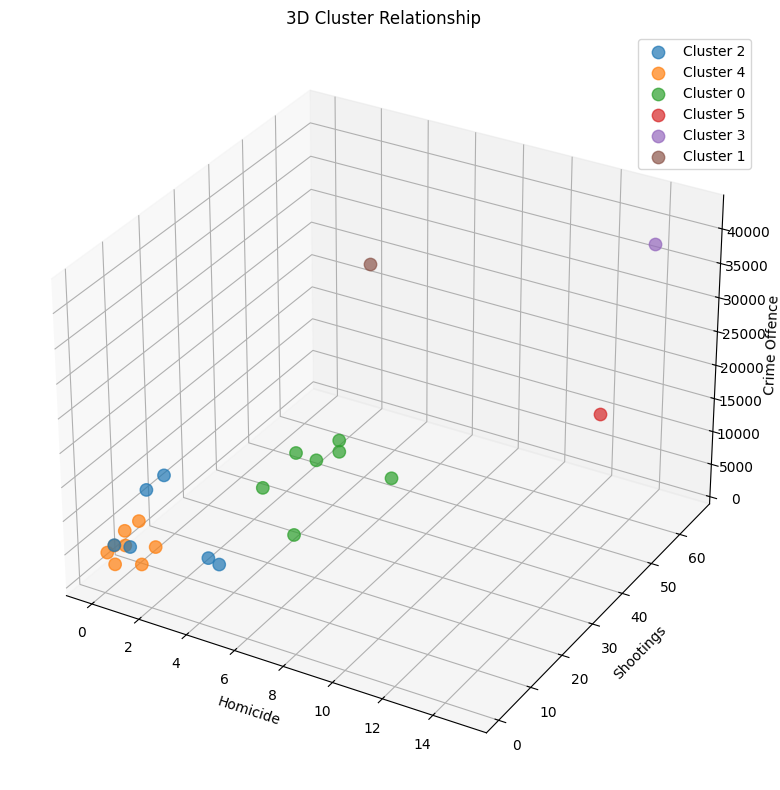

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster
for cluster_label in new_df['cluster'].unique():
    cluster_data = new_df[new_df['cluster'] == cluster_label]
    ax.scatter(
        cluster_data['homicide'],  # X-axis
        cluster_data['shootings'],  # Y-axis
        cluster_data['crimeOffence'],  # Z-axis
        label=f'Cluster {cluster_label}',
        s=80,  # Marker size
        alpha=0.7, 
    )

# Add labels and title
ax.set_title('3D Cluster Relationship')
ax.set_xlabel('Homicide')
ax.set_ylabel('Shootings')
ax.set_zlabel('Crime Offence')
ax.legend()
plt.tight_layout()
plt.show()

#### Distribution of Clusters

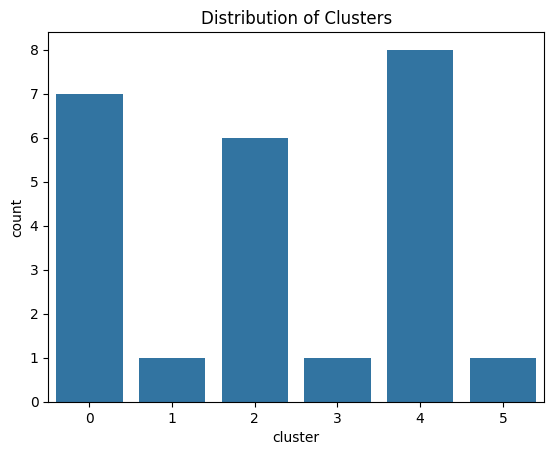

In [40]:
# distribution of clusters
sns.countplot(x = 'cluster', data=new_df)
plt.title('Distribution of Clusters')
plt.show()

From the above chart, cluster 1 has the lowest number of WARDS in the category, we can aggregate the data to see and comparer clusters.

#### Clusters Profile Based on Crime Types

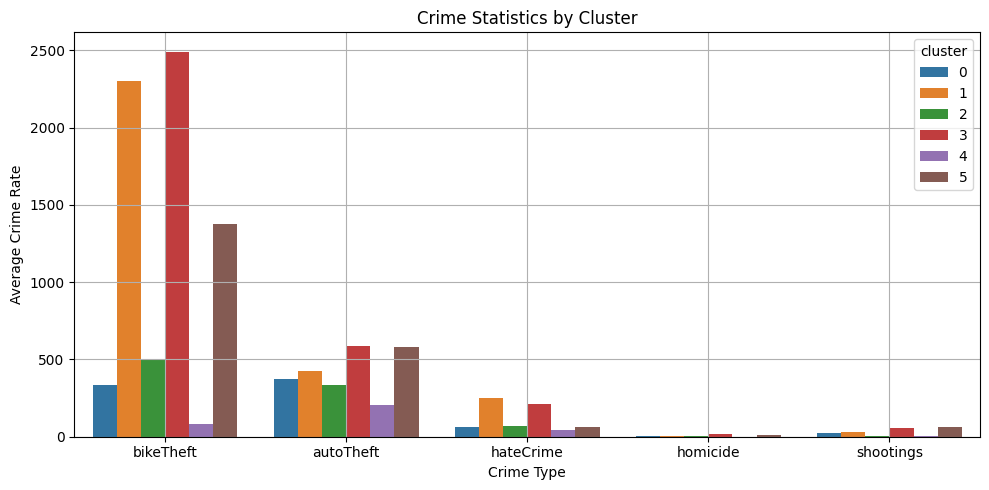

In [34]:
cluster_plot = new_df.groupby('cluster').agg({'bikeTheft':'mean','autoTheft':'mean','crimeOffence':'mean',
                               'hateCrime':'mean','homicide':'mean','shootings':'mean'}).round(2).reset_index()

df_melted = cluster_plot.drop('crimeOffence', axis =1).melt(id_vars='cluster', var_name='Crime Type', value_name='Value')

# Plot using seaborn
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df_melted, 
    x='Crime Type', 
    y='Value', 
    hue='cluster', 
    palette='tab10',
)

# Add titles and labels
plt.title("Crime Statistics by Cluster")
plt.xlabel("Crime Type")
plt.ylabel("Average Crime Rate")
plt.grid(True)
# Show the plot
plt.tight_layout()
plt.show()

Here are observations we can make from each clusters
- Most Dangerous Wards:
    - Cluster 3: Rideau-Vanier
    - Cluster 1: Somerset

- Moderately Safe Wards:
    - Cluster 5: Gloucester-Southgate
    - Cluster 2: Barrhaven West, Kitchissippi, Capital, Orleans East-Cumberland, Orleans South-Navan

- Safest Wards:
    - Cluster 0: Bay, College, Knoxdale-Merivale, River, Alta Vista, Beacon Hill-Cyrville, Rideau-Rockcliffe
    - Cluster 4: Orleans West-Innes, Osgoode, Riverside South-Findlay Creek, Rideau-Jock, Stittsville, Kanata South, Kanata North, West Carleton-March


### Map out the Clusters

In [ ]:
geo_json = ward_map[['WARD_NUM','geometry']] # geometry location for each ward
geo_json['WARD_NUM'] = geo_json['WARD_NUM'].astype(int)

# merge with the cluster
df = new_df.merge(geo_json, left_on='wardNumber', right_on='WARD_NUM', how = 'inner')
map_df = df.merge(ott_ward_df, left_on='wardNumber', right_on='Ward_Number', how='inner')

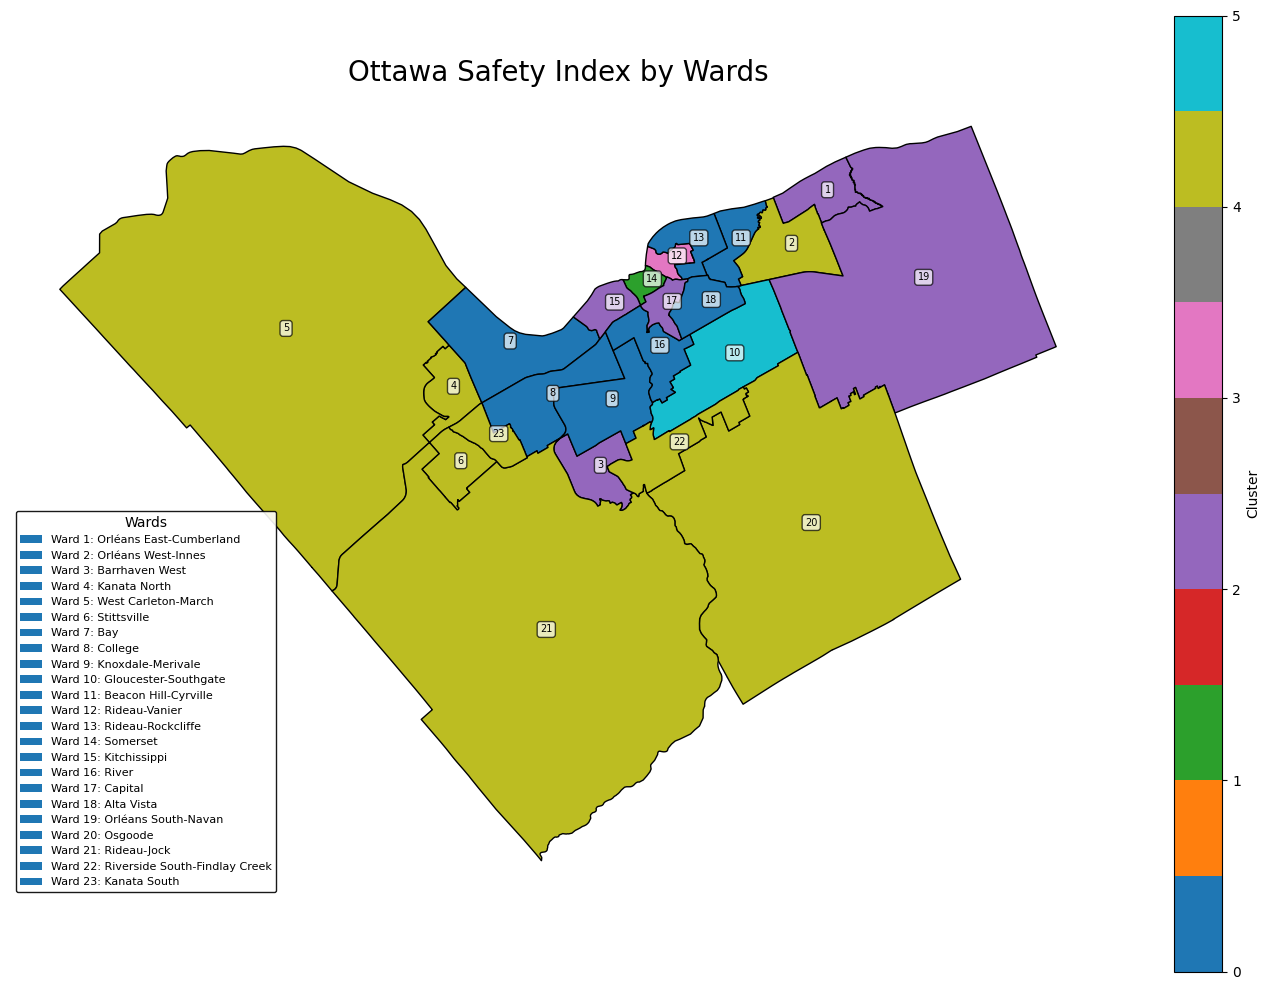

In [36]:
%matplotlib inline
# Assuming your dataframe is already a GeoDataFrame
gdf = gpd.GeoDataFrame(map_df, geometry=map_df['geometry'])

# Plot the geometries, coloring by cluster
fig, ax = plt.subplots(figsize=(14, 10))
gdf.plot(
    column='cluster',  # Column to differentiate clusters
    ax=ax,
    cmap='tab10', 
    legend=True,  # Add legend
    edgecolor = 'black', 
    legend_kwds = {'label':'Cluster'}
)

# Add annotations for ward names
for _, row in gdf.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate(
        text= row['wardNumber'], 
        xy=(centroid.x, centroid.y),
        xytext=(1, 1),  # Offset the text slightly
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
    )


# Generate legend handles
legend_handles = [
    mpatches.Patch(
        label=f"Ward {row['wardNumber']}: {row['Ward_Name']}"
    )
    for _, row in gdf.iterrows()
]

# Add legend to the plot
ax.legend(
    handles=legend_handles,
    title="Wards",
    loc='lower left',
    fontsize=8,
    title_fontsize=10,
    frameon=True,
    framealpha=0.9,
    edgecolor='black'
)

# Add titles and labels
ax.set_title("Ottawa Safety Index by Wards", fontsize=20)
ax.grid(False) # remove grid
ax.set_axis_off()

# Show the plot
plt.tight_layout()
plt.show()


## (Part 2) -Ordering Wards from Safest to Dangerous. 
Now we have an idea of the High, Moderate and Low Crime Areas in Ottawa, lets rank/arrange each ward from the safest to most dangerous. 

#### Calculate a safety index score for each ward.
This is a weighted sum score of crimes, with different crimes carrying different weights. 
Here is how I will be ranking these crimes from bad to worse:
1. Homicide
2. Shootings
3. Hate Crime
4. Criminal Offences
5. Auto Theft
6. Bike Theft

In [37]:
# get a copy of the dataframe
rank_df = new_df.drop('cluster', axis=1).copy()

rank_df['safety_score'] = (
    rank_df['homicide'] * 0.4 +
    rank_df['shootings'] * 0.3 + 
    rank_df['hateCrime'] * 0.2 + 
    rank_df['crimeOffence'] * 0.15 + 
    rank_df['autoTheft'] * 0.15 + 
    rank_df['bikeTheft'] * 0.1
)

# sort the ranks, and merge with the name of each ward
ranks = rank_df.sort_values(by = ['safety_score'], ascending=False)
full_rank = ranks.merge(ott_ward_df, left_on='wardNumber', right_on='Ward_Number', how='inner')
df = full_rank.merge(geo_json, left_on='wardNumber', right_on='WARD_NUM', how = 'outer')

#### Map of Ottawa Safest and Most Dangerous Wards 

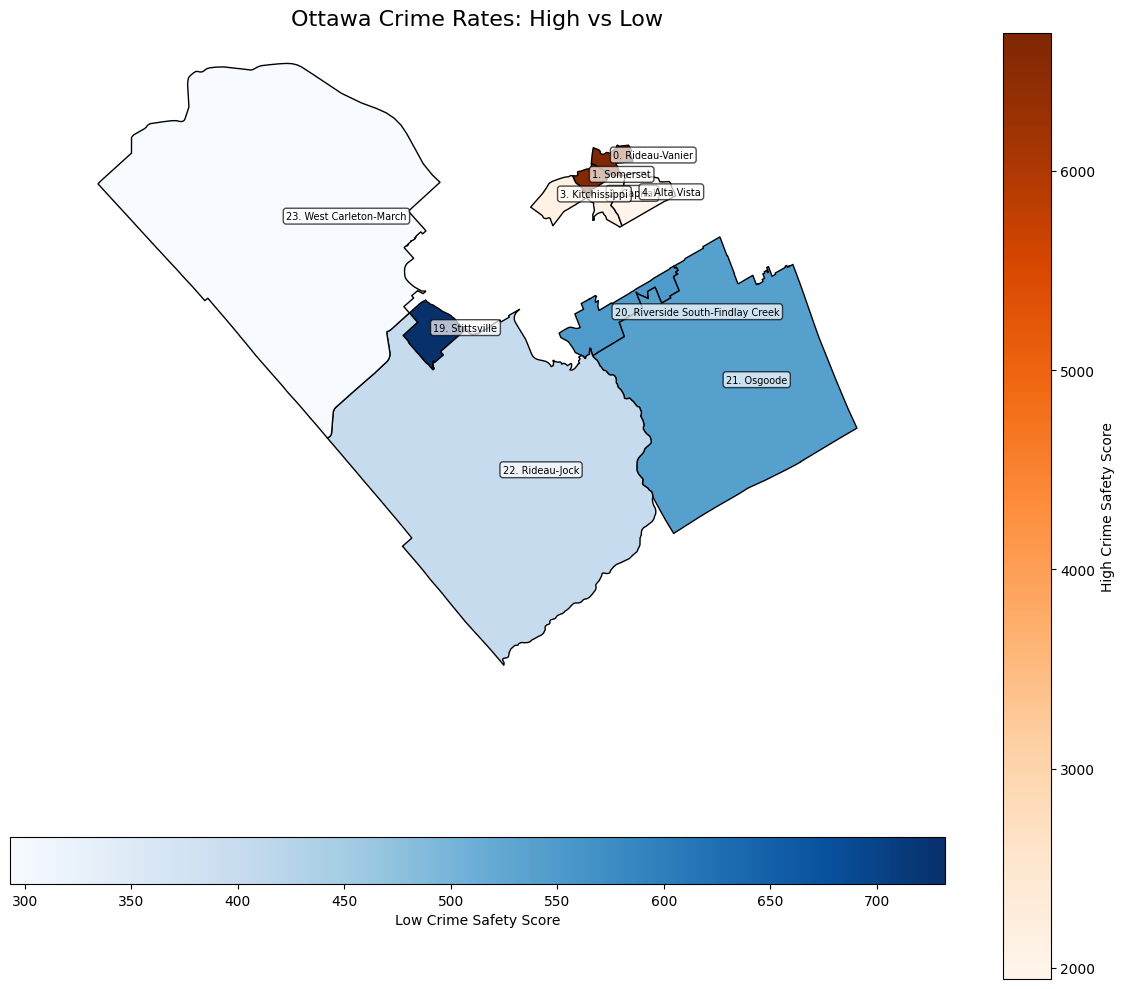

In [38]:
# Separate dataframes for highest and lowest crime rates
high_crime_df = df[['wardNumber', 'Ward_Name', 'safety_score', 'geometry']].iloc[0:5, :].reset_index().rename({'index': 'Rank'}, axis=1)
low_crime_df = df[['wardNumber', 'Ward_Name', 'safety_score', 'geometry']].iloc[19:, :].reset_index().rename({'index': 'Rank'}, axis=1)

# Add a column to differentiate between high and low crime
high_crime_df['crime_type'] = 'High Crime'
low_crime_df['crime_type'] = 'Low Crime'

# Combine the two dataframes
combined_df = pd.concat([high_crime_df, low_crime_df], ignore_index=True)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(combined_df, geometry='geometry')

# Plot the combined data
fig, ax = plt.subplots(figsize=(12, 10))
high_crime = gdf[gdf['crime_type'] == 'High Crime']
low_crime = gdf[gdf['crime_type'] == 'Low Crime']

# Plot high crime areas in orange
high_crime.plot(
    column='safety_score',
    ax=ax,
    cmap='Oranges',
    legend=True,
    edgecolor='black',
    legend_kwds={'label': 'High Crime Safety Score'}
)

# Plot low crime areas in blue
low_crime.plot(
    column='safety_score',
    ax=ax,
    cmap='Blues',
    legend=True,
    edgecolor='black',
    legend_kwds={'label': 'Low Crime Safety Score', 'orientation' : 'horizontal'}
)

# Add annotations for ward names
for _, row in gdf.iterrows():
    centroid = row['geometry'].centroid 
    ax.annotate(
        text=f"{row['Rank']}. {row['Ward_Name']}", 
        xy=(centroid.x, centroid.y),
        xytext=(1, 1),  # Offset the text slightly
        textcoords="offset points",
        fontsize=7,
        color="black",
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.7)
    )

# Add titles and labels
ax.set_title("Ottawa Crime Rates: High vs Low", fontsize=16)
ax.grid(False)  # Remove grid
ax.set_axis_off()  # Turn off axis labels

# Show the plot
plt.tight_layout()
plt.show()


From the map above, we can observe that the further out a ward is from downtown Ottawa, the safer the area. 

### Full Ranking of Ottawa Wards by Safety

In [50]:
full_rank.merge(geo_json, left_on='wardNumber', right_on='WARD_NUM', how = 'outer').sort_values(by='safety_score', ascending=True)[['Ward_Name','safety_score']]

,Ward_Name,safety_score
23,West Carleton-March,293.05
22,Rideau-Jock,401.90
21,Osgoode,540.45
20,Riverside South-Findlay Creek,550.45
19,Stittsville,731.95
18,Kanata North,750.90
17,Barrhaven East,785.70
16,Orléans East-Cumberland,817.30
15,Orléans West-Innes,846.75
14,Kanata South,894.25


##### Thanks for viewing this Noetebook!